# <p style="text-align:center;"> No supervizado </p>

**Todo ejercicio debe tener un análisis fundamentado en la teoría vista en la materia, dicho análisis sera parte del informe a entregar en pdf**

- <span style="color:blue">*Se recomienda hacer uso de las herramientas vistas en los demos de la materia.*</span>

- <span style="color:red">**Usar lo hecho en el práctico Análisis Exploratorio y Curación de Datos**.</span>


**Objetivos:** 
- Implementar modelos de clustering, variando el número de clusters.
- Usar embeddings:  PCA, correlación y t-distributed stochastic neighbor.

Implementar dos modelos de clustering con y sin embeddings uno de ellos k-means.

Realizar un análisis de lo obtenido. 
- Es muy recomendable integrar indicadores de mala calidad como por ejemplo "hay un cluster muy grande y el resto son muy chicos", lo cual indica que en el espacio no se distinguen bien grupos separados y hay que usar otro espacio 
- Evaluar con Silohuette y pureza con algunos datos etiquetados.

**Librerías**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)

**Funciones**

In [3]:
def galaxy_morf(row):
    if row["elliptical"]:
        return "E"
    elif row["spiral"]:
        return "S"
    else:
        return "I"
    
def distribution_per_type(df, col_name="", bins=20):
    #]plt.title(f"{col_name.capitalize()} Distribution")
    sns.distplot(df[df["elliptical"] == 1][col_name],label="elliptical", bins=bins)
    sns.distplot(df[df["spiral"] == 1][col_name],label="spiral", bins=bins)
    sns.distplot(df[df["uncertain"] == 1][col_name],label="irregular", bins=bins)
    plt.legend()
    
def exploratory_plots(df, col_name=""):
    plt.subplot(3, 1, 1)
    distribution_per_type(df, col_name)
    plt.subplot(3, 1, 2)
    #plt.title(f"{col_name.capitalize()} Boxplot")
    sns.boxplot(x="type", y=col_name, data=df, **box_params)
    plt.subplot(3, 1, 3)
   # plt.title(f"{col_name.capitalize()} Boxplot w/o Outliers")
    sns.boxplot(x="type", y=col_name, data=df, showfliers=False, **box_params)
    
    plt.tight_layout()
    
def num_type(row):
    if row["type"] == "I":
        return 1
    elif row["type"] == "S":
        return 2
    else:
        return 3

def plot_silouette(silhouette_values, cluster_labels, silhouette_avg, 
                   title="Visualizacion de los datos"):
    fig, ax1 = plt.subplots(1, 1)
    y_lower = 10
    n_clusters = len(np.unique(cluster_labels))
    for i in np.unique(cluster_labels):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color   = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(title)
    # ax1.set_xlabel("espacio de la primera caracteristica")
    # ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

<span style="color:red">**Comente el preprocesado y curación que ha realizado sobre los datos fotometricos y morfologicos crudos**</span>  

<span style="color:red">**Cargue el dataset correspondiente a los datos fotometricos y morfologicos de las galaxias pre-procesado y curado.**</span>  


# 1- Dataset
El dataset original consta de 92.102 registros y 14 variables y no posee valores faltantes.

Las variables son: `objID`, `'ra'`, `'dec'`, `'modelMag_u'`, `'modelMag_g'`, `'modelMag_r'`,`'modelMag_i'`,
`'modelMag_z'`,`'petroR90_r'`,`'z'`, `'Color'`,`'elliptical'`, `'spiral'` y `'uncertain'`.

El preprocesado usado fue hecho anteriormente en el trabajo 2 de la materia "Análisis Exploratorio y Curación de Datos"
y a continuacion se resumen paso a paso la limpieza y curacion implementada.

## 1.1- Pre-Procesado

Se añade una columna con la clase de cada galaxia, asignando la etiqueta ‘I’ (de irregular) a las
galaxias con etiqueta ‘uncertain’.
Se setea a la columna ‘objID’ como el id del dataframe.
Se encontraron 34421 objetos con id repetido. Debido a que nuestro dataset es lo
suficientemente grande y para evitar conflictos entre datos, decidimos eliminar los duplicados y el
dataset queda con 57681 datos, lo cual consideramos que, a nuestros fines, es una cantidad
suficiente para realizar estadística.

#### 1.1.1- KNN sobre valores atipicos

Se imputaron usando KNN las columnas que caen fuera de un intervalo definido por una cota inferior y una cota superior. la cota inferior elegida para las magnitudes luminicas aparentes (`'modelMag_u'`, `'modelMag_g'`, `'modelMag_r'`,`'modelMag_i'`,
`'modelMag_z'`) y para el tamaño (`'petroR90_r'`)  fue de 0, tambien se filtraron outliers de color. Las cotas superiores aplicadas a las magnitudes aparentes se eligieron segun el criterio;

`'modelMag_u'`=22.0,

`'modelMag_g'`=22.2,	

`'modelMag_r'`=22.2,	

`'modelMag_i'`=21.3,	

`'modelMag_z'`=20.5

Extraidas de https://classic.sdss.org/dr4/

Se escalaron los datos y se procedio a realizar la imputación utilizando todas las columnas como input.

#### 1.1.2-  Eliminacion de outliers

Por ultimo se eliminaron los outliers con el criterio Q1*2.5 < x < Q3*2.5 y se creó el
dataframe df1 (guardado en csv como "galaxias_curadas"), de 56545 datos, es decir, se eliminaron el 1.97% de datos.
	





**Load**

In [4]:
data = pd.read_csv('galaxias_curadas') #usamos el dataset curado en el entregable 2

# Clases
data["type"] = data.apply(galaxy_morf, axis=1)


# variable Númerica**

data["type_n"] = data.apply(num_type, axis=1)


display(data.head(2))
display (data.shape)
data.describe()

,objID,ra,dec,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,petroR90_r,z,Color,elliptical,spiral,uncertain,clase,type,type_n
0,"1,23765119242489E+018",116.519097,39.886407,0.429235,0.429182,0.436968,0.477502,0.510150,0.000096,0.717351,0.875127,0,1,0,S,S,2
1,"1,23765149575578E+018",116.451900,41.421270,0.477759,0.378912,0.343713,0.364403,0.375489,0.000113,0.673681,0.778513,0,0,1,I,I,1


(56545, 17)

,ra,dec,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,petroR90_r,z,Color,elliptical,spiral,uncertain,type_n
count,56545.000000,56545.000000,56545.000000,56545.000000,56545.000000,56545.000000,56545.000000,56545.000000,56545.000000,56545.000000,56545.000000,56545.000000,56545.000000,56545.000000
mean,183.402710,25.400552,0.510642,0.456987,0.442683,0.479393,0.505389,0.000105,0.536541,0.834744,0.073163,0.339782,0.587055,1.486108
std,57.709405,18.622262,0.119051,0.101329,0.100854,0.111333,0.121429,0.000052,0.282370,0.037715,0.260406,0.473639,0.492368,0.629397
min,0.008745,-11.202394,0.054662,0.097467,0.094478,0.104583,0.108045,0.000005,0.000000,0.645105,0.000000,0.000000,0.000000,1.000000
25%,151.364561,10.506527,0.431368,0.387818,0.372170,0.400474,0.417797,0.000067,0.303909,0.801647,0.000000,0.000000,0.000000,1.000000
50%,183.904718,23.910305,0.521947,0.472666,0.458998,0.496978,0.523866,0.000095,0.541897,0.840854,0.000000,0.000000,1.000000,1.000000
75%,221.679881,39.433792,0.596090,0.538112,0.526413,0.571509,0.605457,0.000132,0.787953,0.864559,0.000000,1.000000,1.000000,2.000000
max,359.965567,70.133213,1.000000,0.891862,0.858650,1.000000,1.000000,0.000300,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [5]:
data['elliptical'].unique()

array([0, 1], dtype=int64)

# Clustering

## Muestra Estratificada

In [6]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2411)

In [7]:
for train_idx, test_idx in sss.split(data, data["type_n"]):
    #strat_train_set = data_cl.loc[train_idx]
    strat_test_set  = data.iloc[test_idx]

Análisis sin variables de ubicación y tipo

In [8]:
type_cols      = ['ra','dec','objID','elliptical', 'spiral', 'uncertain', 'type', 'type_n','clase']

# escalar
data_clus      = strat_test_set.drop(type_cols, axis=1)
data_clus_cols = data_clus.columns
data_clus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11309 entries, 11896 to 25654
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   modelMag_u  11309 non-null  float64
 1   modelMag_g  11309 non-null  float64
 2   modelMag_r  11309 non-null  float64
 3   modelMag_i  11309 non-null  float64
 4   modelMag_z  11309 non-null  float64
 5   petroR90_r  11309 non-null  float64
 6   z           11309 non-null  float64
 7   Color       11309 non-null  float64
dtypes: float64(8)
memory usage: 795.2 KB


In [9]:
data_clus      = pd.DataFrame(data=StandardScaler().fit_transform(data_clus), 
                             columns=data_clus_cols)

data_clus

,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,petroR90_r,z,Color
0,1.072203,1.168489,1.371985,1.509849,1.547033,0.103924,-0.728974,0.891647
1,-1.294251,-1.739394,-1.830894,-1.835929,-1.849583,2.108399,0.117923,-1.422837
2,-0.119747,-0.453902,-0.481549,-0.448831,-0.435372,0.494192,-0.420203,-0.752978
3,-0.115758,0.377344,0.558808,0.657414,0.688330,-0.983156,-1.409070,1.313427
4,-1.684730,-1.825993,-1.749488,-1.719167,-1.682842,2.305685,-0.780016,-0.589322
...,...,...,...,...,...,...,...,...
11304,-0.498011,-0.364623,-0.320488,-0.357194,-0.440934,0.600454,0.118936,0.218291
11305,-1.501985,-2.126752,-2.254474,-2.247744,-2.243992,1.899721,-0.743961,-1.909831
11306,-2.058550,-1.811803,-1.627258,-1.560552,-1.506809,0.581859,0.960105,0.296948
11307,0.428169,0.582236,0.667522,0.695046,0.714734,0.305021,0.267321,0.594978


### K-Means

In [10]:
range_n_clusters = [2, 3, 4, 5, 6, 7]

def serch_k_optimus(data_clus, range_n_clusters):
    sse = {}
    for n_clusters in range_n_clusters:
        
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        
        # "Start fitting"
        cluster_labels = clusterer.fit_predict(data_clus)
        
        # "Stop fitting"
        sse[n_clusters] = clusterer.inertia_

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(data_clus, cluster_labels, random_state=352)
        print("Para n_clusters =", n_clusters,
              "El silhouette_score promedio es :", silhouette_avg)

        
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data_clus, cluster_labels)

        plot_silouette(sample_silhouette_values, cluster_labels,
                       silhouette_avg, title="k={}".format(n_clusters))
    return sse


C:\Users\joaqu\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 2 El silhouette_score promedio es : 0.39953428584614104


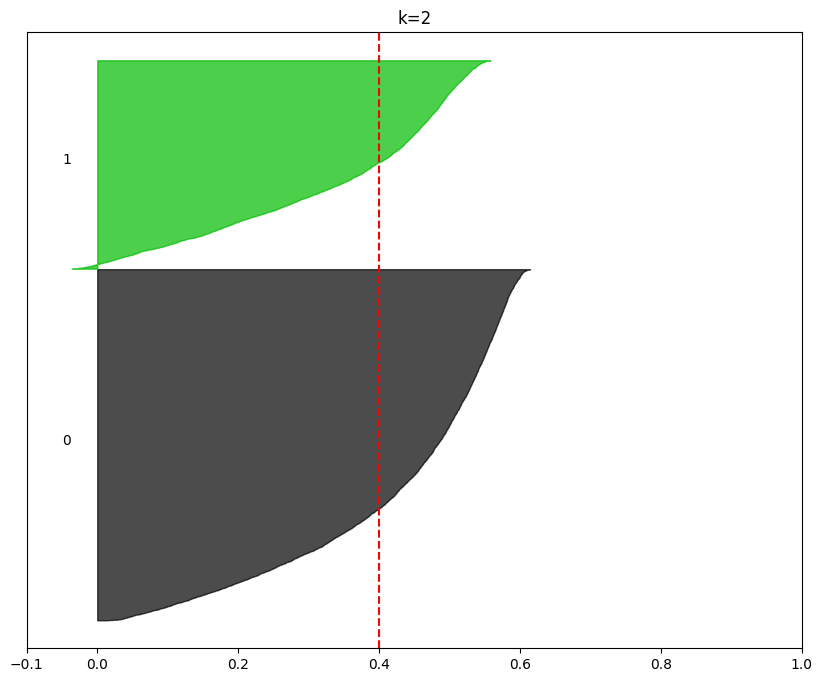

C:\Users\joaqu\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 3 El silhouette_score promedio es : 0.2805523577032078


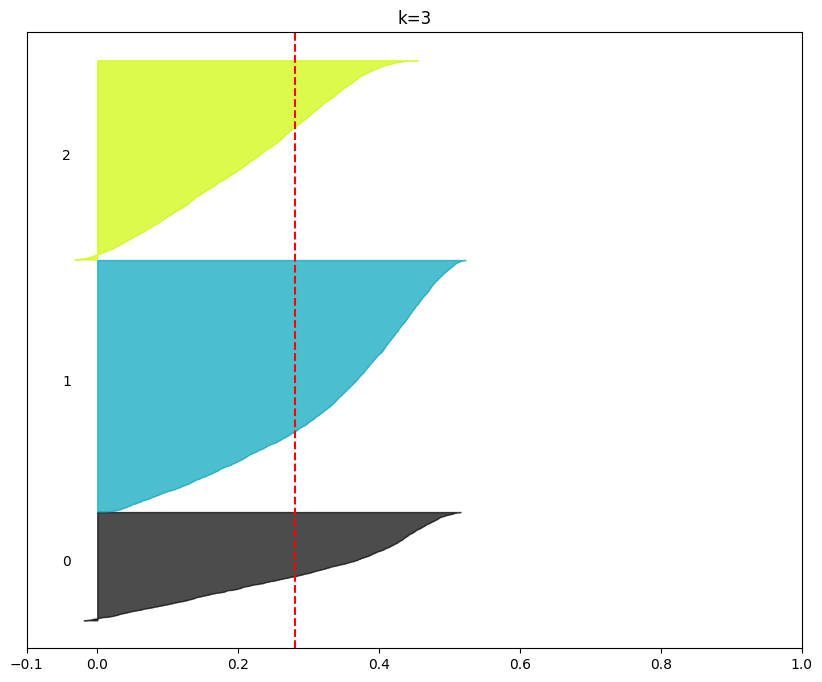

C:\Users\joaqu\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 4 El silhouette_score promedio es : 0.2412817400535265


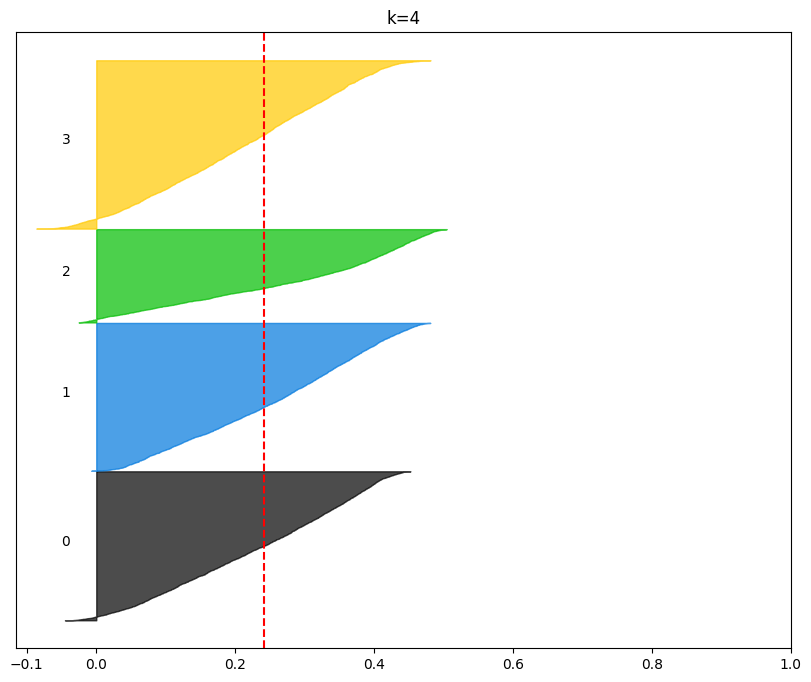

C:\Users\joaqu\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 5 El silhouette_score promedio es : 0.24074437042400673


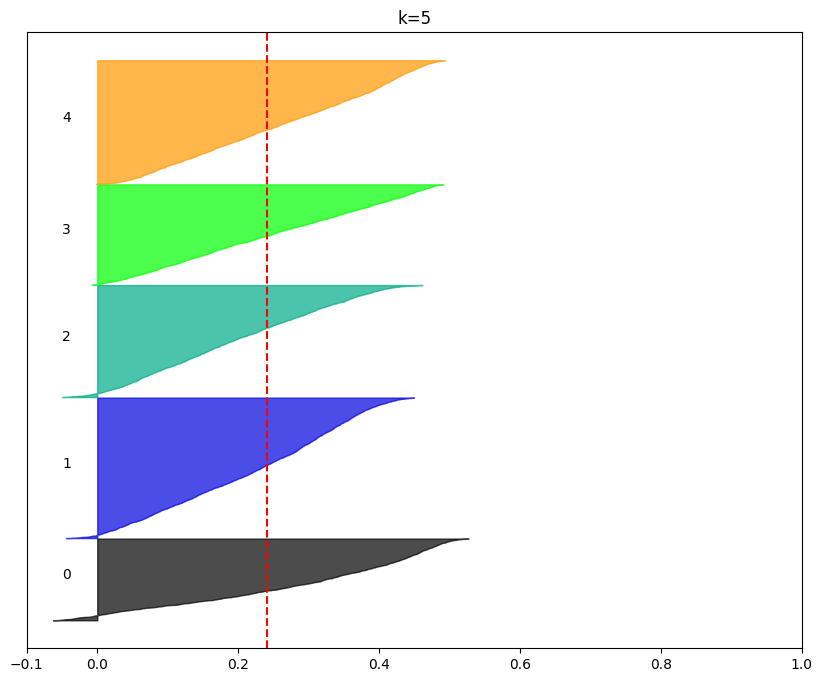

C:\Users\joaqu\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 6 El silhouette_score promedio es : 0.23801283443608284


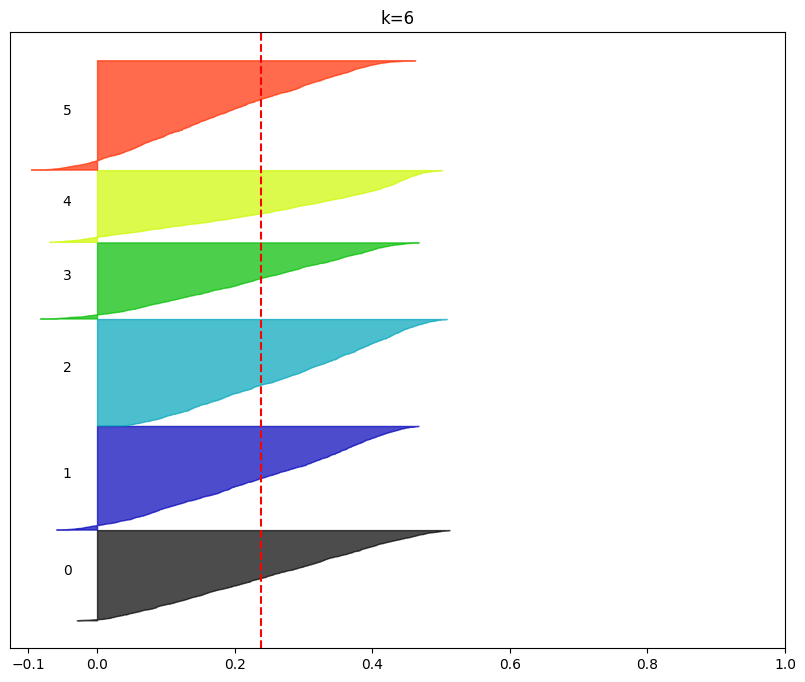

C:\Users\joaqu\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 7 El silhouette_score promedio es : 0.23841961066286071


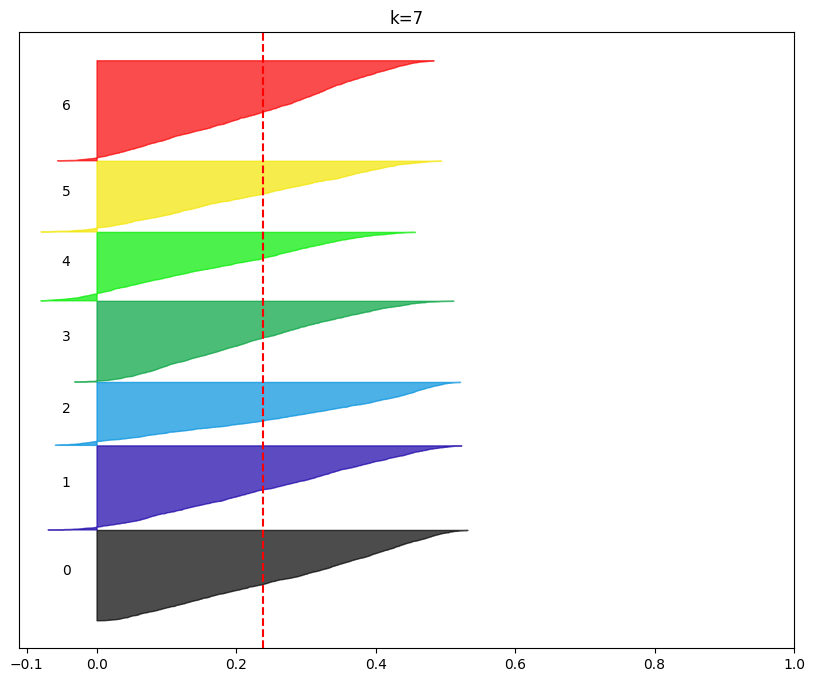

In [11]:
sse = serch_k_optimus(data_clus, range_n_clusters)

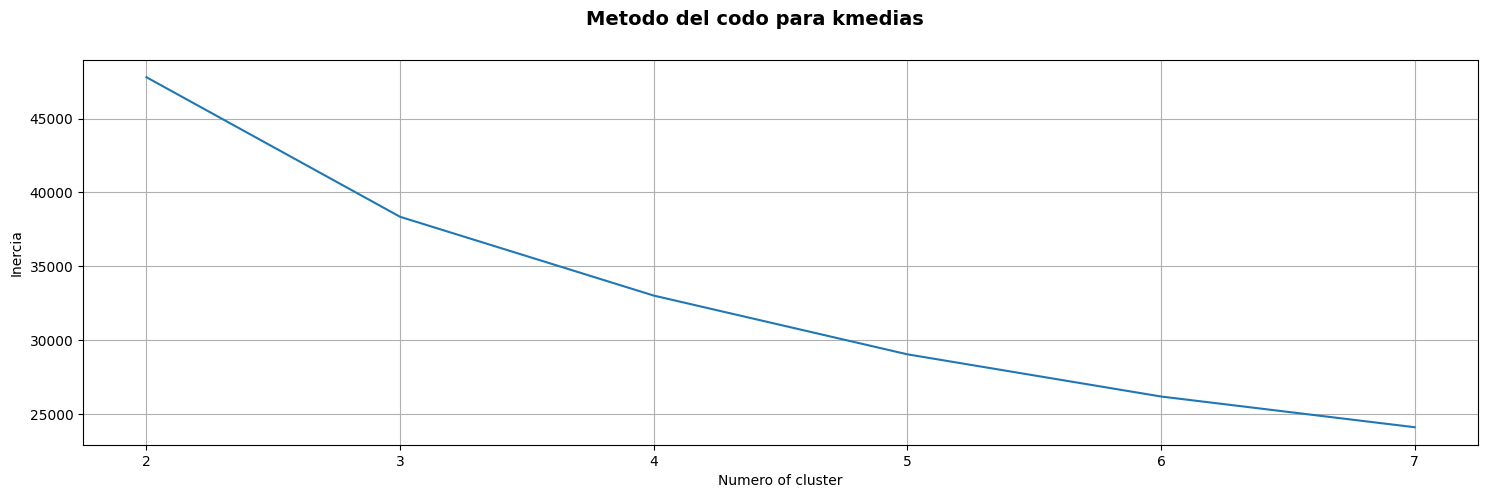

In [12]:
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 5)
plt.suptitle(("Metodo del codo para kmedias "),
                 fontsize=14, fontweight='bold')
ax1.plot(list(sse.keys()), list(sse.values()))
ax1.set_xlabel("Numero of cluster")
ax1.set_ylabel("Inercia")
plt.grid()

<span style="color:red">**Responda:**</span>

<span style="color:red">**Explique brevemente cual es el objetivo de aplicar el metodo k-means y las siluetas**</span>  

K-means es un algoritmo no supervisado de Clustering, cuyo objetivo es agrupar en k clusteres disjuntos a cada dato de nustro dataset. El numero de clusteres es un parametro, y el centroide de cada cluster se puede inicializar de forma aleatoria o elegir manualmente si se tienen conocimientos de dominio que permitan hacerlo (entre otras formas). Luego cada dato es asignado al cluster cuyo centroide este mas cerca (se busca minimizar la inercia o la suma de cuadrados de cada cluster). Luego se calcula la media geometrica de cada cluster y es asignada como el nuevo centroide. Con este centroide se repiten los pasos anteriores hasta alcanzar un criterio que puede ser de convergencia (los centroides no varian significativamente), o de maximo de iteraciones. Finalmente se elijen los clusteres que hayan minimizado la suma de cuadrados dentro de cada cluster.
Notar que cada vez que se repite el proceso se pueden obtener diferentes resultados ya que el modelo es suceptible a ubicacion inicial de los centroides, por lo cual la convergencia no esta garantizada.

El metodo de las siluetas permite medir, usando el coeficiente de silueta, que tan fuerte es la identificacion de un dato y su cluster con respecto a otros clusters.


<span style="color:red">**Qué pueden decir en general de las siluetas para cada k?**</span>  

Los graficos de silueta mostrados mas arriba,muestran el score de silueta de cada punto de cada cluster. Mientras mas uniforme y larga es cada silueta, mejor se identifican los datos con sus respectivos clusters. Mientras mas grande el score mejor

En nuestro caso parece que k=3 es una buena cantidad de clusers a elegir, con un score de 0.2805523577032078. 2 clusters tambien es una buena opcion, con el mejor score de todos 0.39953428584614104. 

<span style="color:red">**Qué  pueden decir acarca del score cuando incrementa el número de clusters?**</span> 

Disminuye muy lentamente a partir de k=4.

<span style="color:red">**Según el método del codo más el análisis de las siluetas, que número de clusters es el mejor?**</span>

El codo se identifica en k=3, en este punto la curva presenta el angulo con mayor pronunciacion, aunque no resalta demasiado entre los otros k.

### <span style="color:red">**Elija el número de clusters K en función de su anális**</span> 

In [13]:
K= 3
cluster_K = KMeans(n_clusters=K, random_state=10)
cluster_labels_K = cluster_K.fit_predict(data_clus)

data_clus["cluster_label"] = cluster_labels_K

C:\Users\joaqu\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Visualizacion segun cluster label

In [14]:
def distribution_per_label(df, col_name="", bins=20):
    plt.title(f'{col_name.capitalize()} Distribution')
    for kk in df["cluster_label"].unique():
        sns.distplot(df[df["cluster_label"] == kk][col_name],label=f'cluster_label={kk}', 
                     bins=bins)
    plt.legend()
    
def exploratory_plots_label(df, col_name=""):
    plt.subplot(2, 1, 1)
    distribution_per_label(df, col_name)
    plt.subplot(2, 1, 2)
    #plt.title(f"{col_name.capitalize()} Boxplot w/o Outliers")
    sns.boxplot(x="cluster_label", y=col_name, data=df, showfliers=False)
    
    plt.tight_layout()

### Color

C:\Users\joaqu\AppData\Local\Temp\ipykernel_6660\533041309.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df["cluster_label"] == kk][col_name],label=f'cluster_label={kk}',
C:\Users\joaqu\AppData\Local\Temp\ipykernel_6660\533041309.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df

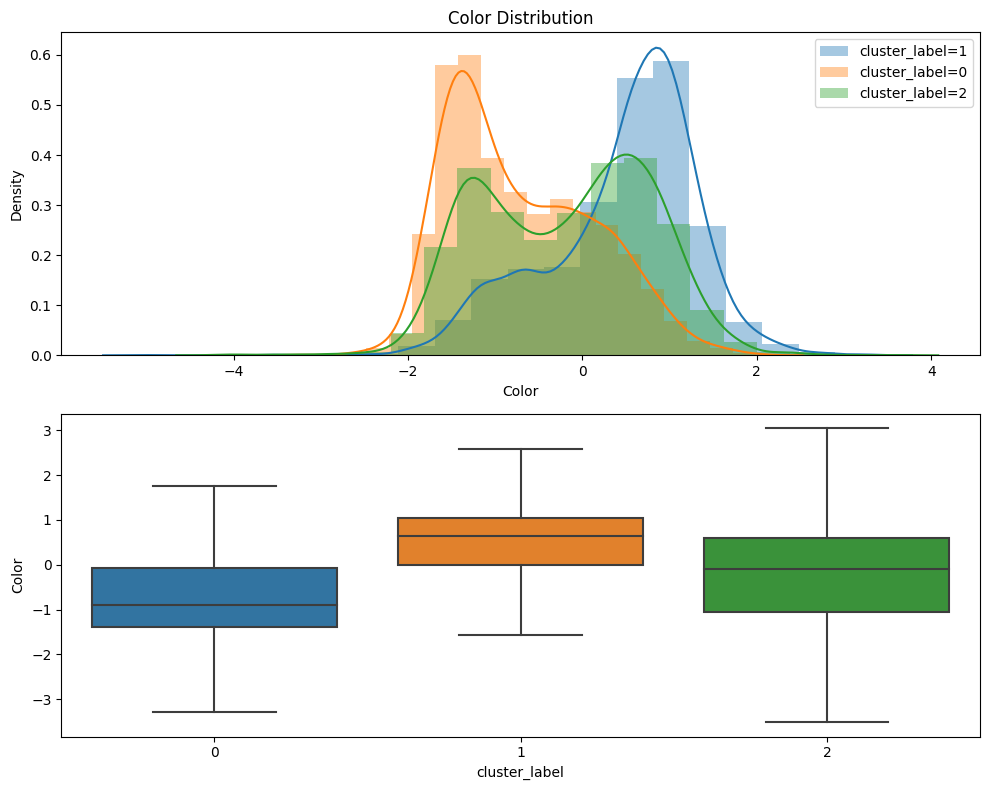

In [15]:
exploratory_plots_label(data_clus, "Color")

### Petro R90

C:\Users\joaqu\AppData\Local\Temp\ipykernel_6660\533041309.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df["cluster_label"] == kk][col_name],label=f'cluster_label={kk}',
C:\Users\joaqu\AppData\Local\Temp\ipykernel_6660\533041309.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df

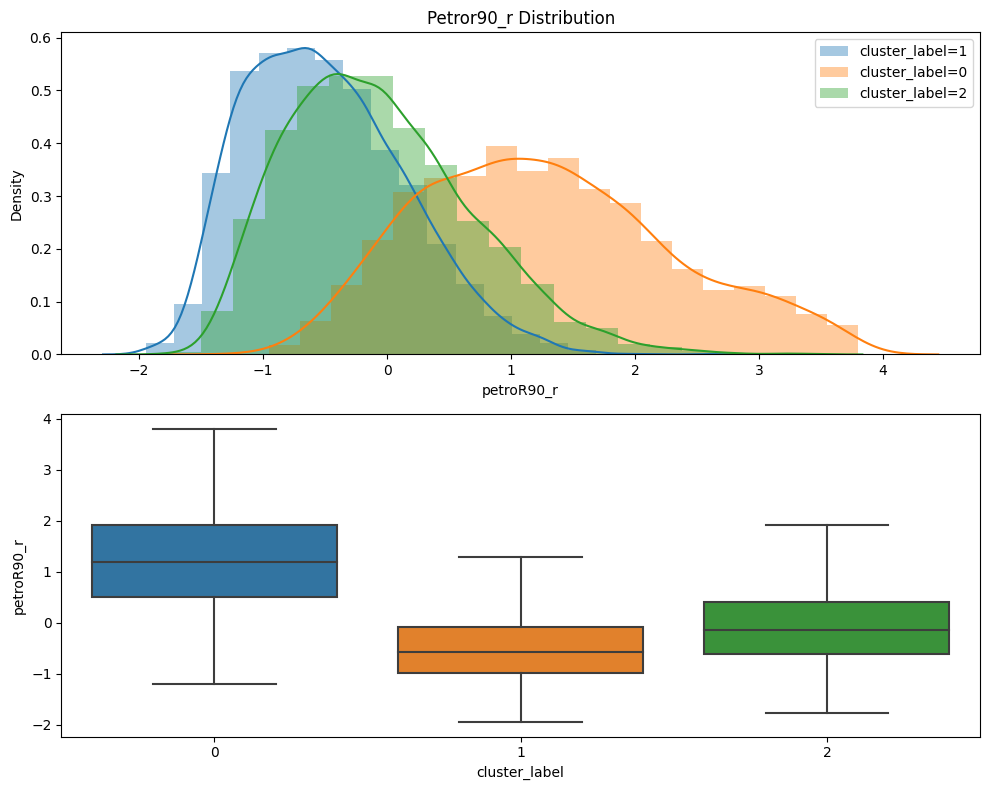

In [16]:
exploratory_plots_label(data_clus, "petroR90_r")

### Mag Distributions

C:\Users\joaqu\AppData\Local\Temp\ipykernel_6660\533041309.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df["cluster_label"] == kk][col_name],label=f'cluster_label={kk}',
C:\Users\joaqu\AppData\Local\Temp\ipykernel_6660\533041309.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df

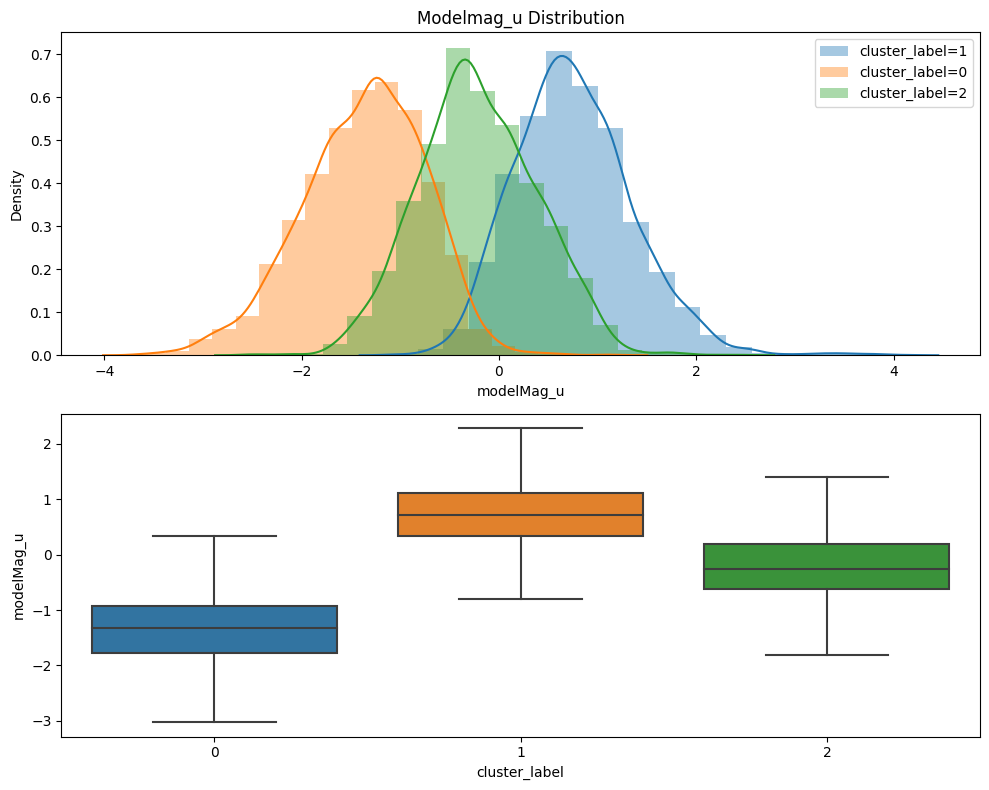

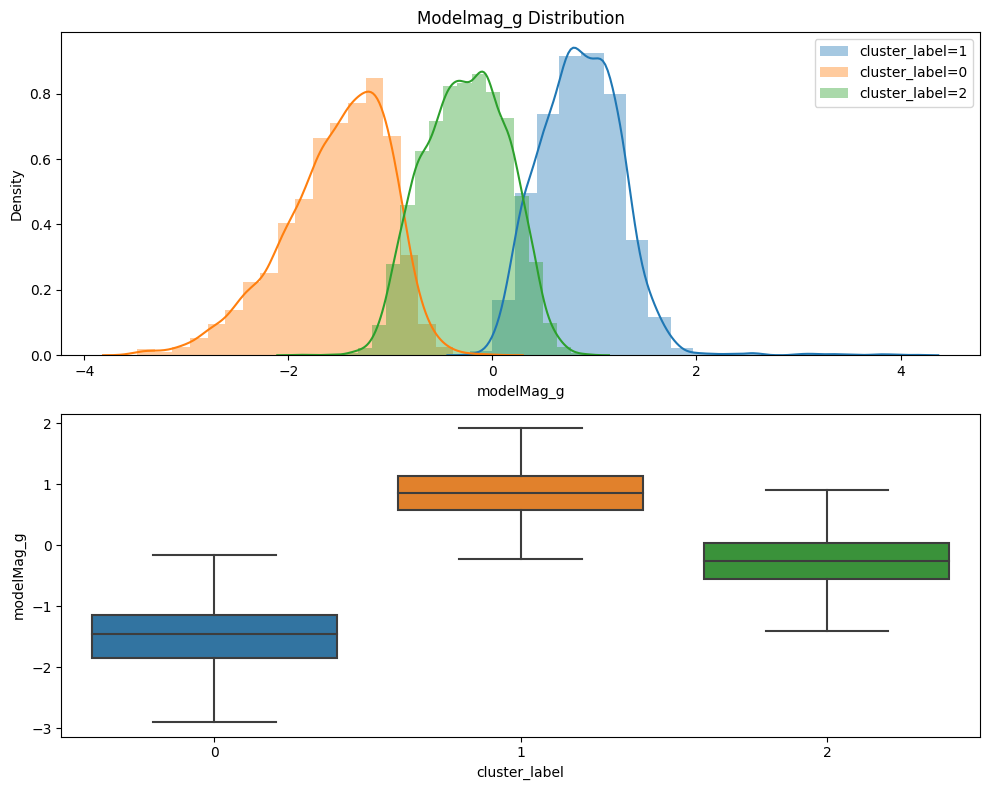

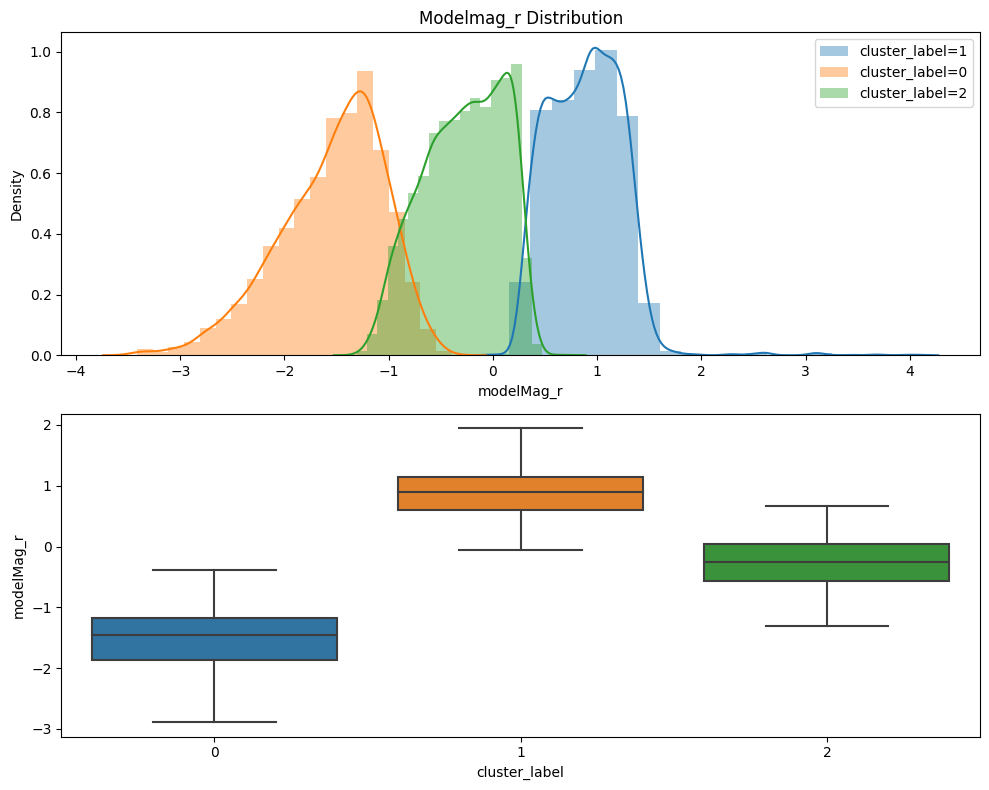

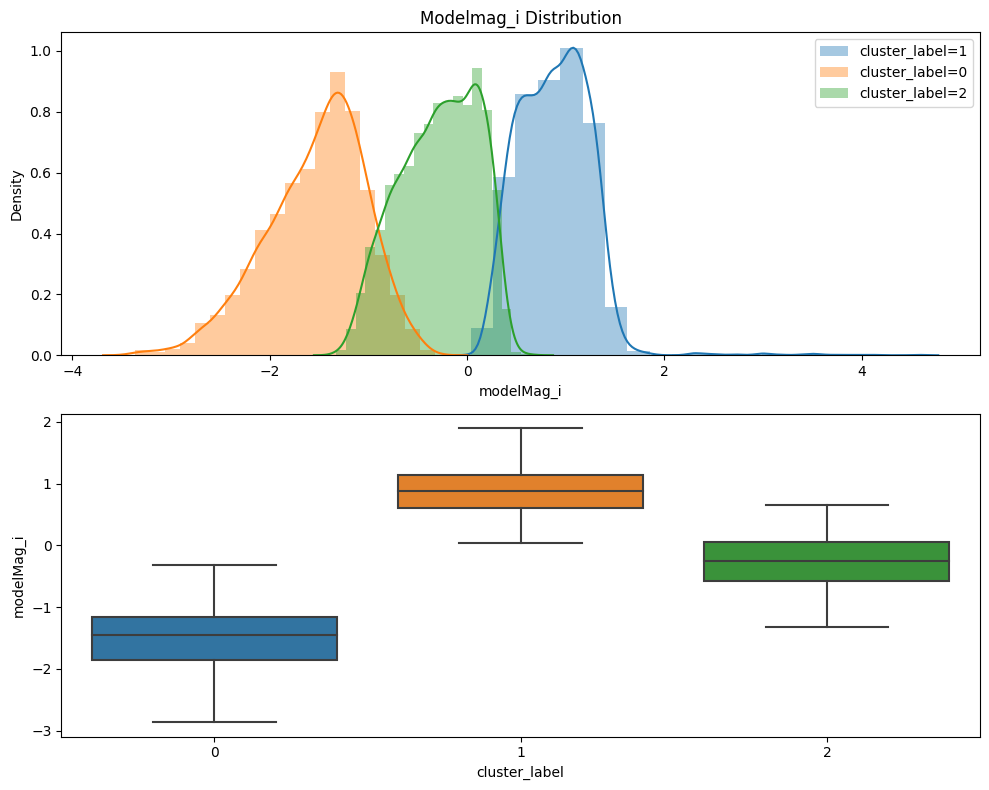

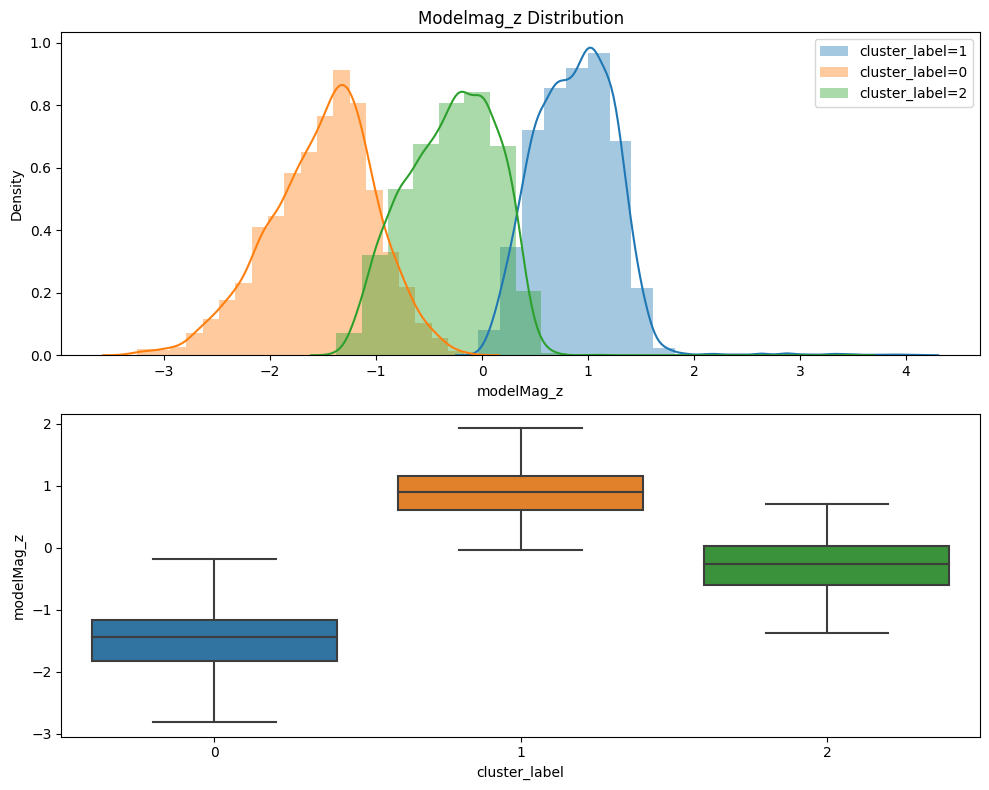

In [17]:
for mag in ['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i','modelMag_z']:
    plt.figure()
    exploratory_plots_label(data_clus, mag)

<span style="color:red">**Que puede decir de los anteriores gráficos?**</span>  

### color
Con respecto al grafico de color, se observan diferencias significativas entre los clusters 0 y 1. Tambien se observa el cluster 2 con bimodalidad, esto puede sugerir que a su vez el cluster 2 puede estar conformado por dos subclusters.
El grafico es muy similar al obtenido cuando se visualizo la distribucion de la clase color distinguiendo por clase de galaxia, hecho en el entregable 1 de la materia.
### Petro R90
Los boxplot muestran nuevamente una clara separacion entre los clusters 0 y 1, intuyendo que el cluster 0 corresponde con las galaxias mas grandes y con indice de color mas rojizo, mientras que el cluster 1 se corresponde con galaxias chicas y azuladas
El cluster 2 contiene galaxias con valores quizas mas promedio y mas desparramados.
### Magnitudes
Los boxplot de todas las magnitudes muestran clara separacion de clusters, con el cluster 0 correspondiendo a las galaxias mas debiles en su correspondiente magnitud, seguidas por el cluster 2 que nuevamente parece tener un valor promedio, y por ultimo el cluster 1 con los valores mas altos de magnitud u, siguiendose nuevamente la tendencia. 

La tendencia parece resumirse como sigue:

Cluster 0: Galaxias chicas, azuladas y poco brillantes.

Cluster 1: Galaxias Grandes, rojizas y brillantes.

Cluster 2: Galaxias que no entran en los clusters anteriores y tienen valores mas bien promedio o valores no-extremos.

In [18]:
data_clus['cluster_label'].value_counts()

1    5088
2    4031
0    2190
Name: cluster_label, dtype: int64

<span style="color:red">**Con el número de clusters elegidos (k) elejido implemente los siguientes embeddings**</span> 

In [19]:
data_clus_N = data_clus
data_clus_N.columns

Index(['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z',
       'petroR90_r', 'z', 'Color', 'cluster_label'],
      dtype='object')

# Embeddings

In [20]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [21]:
def print_title(title="", delimiter="*"):
    print(delimiter*80)
    print(title)
    print(delimiter*80)

In [22]:
def plot_3d(pca, df, colname=""):
    from mpl_toolkits.mplot3d import Axes3D 
    fig = plt.figure(figsize=(15, 10))
    for idx in range(1, 5):
        ax = fig.add_subplot(2,2,idx, projection='3d')
        im = ax.scatter(pca[:,0], pca[:,1], pca[:,2], 
               c = df[colname], cmap=plt.get_cmap("jet"),
                        alpha=0.5)
        ax.view_init(30, 45+90*idx)
        ax.set_xlabel("Axis 1")
        ax.set_ylabel("Axis 2")
        ax.set_zlabel("Axis 3")
        fig.colorbar(im, ax=ax)

In [23]:
def plot_2d(pca, df, colname=""):
    from mpl_toolkits.mplot3d import Axes3D 
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    im = ax.scatter(pca[:,0],pca[:,1],
                    c=df[colname],cmap=plt.get_cmap("jet"),
                    alpha=0.5)
    ax.set_xlabel("Axis 1")
    ax.set_ylabel("Axis 2")
    fig.colorbar(im, ax=ax)

## PCA

In [24]:
pca_3dim = PCA(n_components=3)
pca_2dim = PCA(n_components=2)


pca_std_3d = pca_3dim.fit_transform(data_clus_N)
pca_std_2d = pca_2dim.fit_transform(data_clus_N)


In [25]:
print_title("3D")
print("nombre_modelo", pca_3dim.explained_variance_ratio_, sum(pca_3dim.explained_variance_ratio_))

print_title("2D")
print("nombre_modelo", pca_2dim.explained_variance_ratio_, sum(pca_2dim.explained_variance_ratio_))


********************************************************************************
3D
********************************************************************************
nombre_modelo [0.63753095 0.16016834 0.08702878] 0.8847280648634217
********************************************************************************
2D
********************************************************************************
nombre_modelo [0.63753095 0.16016834] 0.7976992859363549


In [26]:
axis_components = pd.DataFrame(index=data_clus.columns, columns=["Ax1", "Ax2", "Ax3"], 
                                  data=pca_3dim.components_.T)

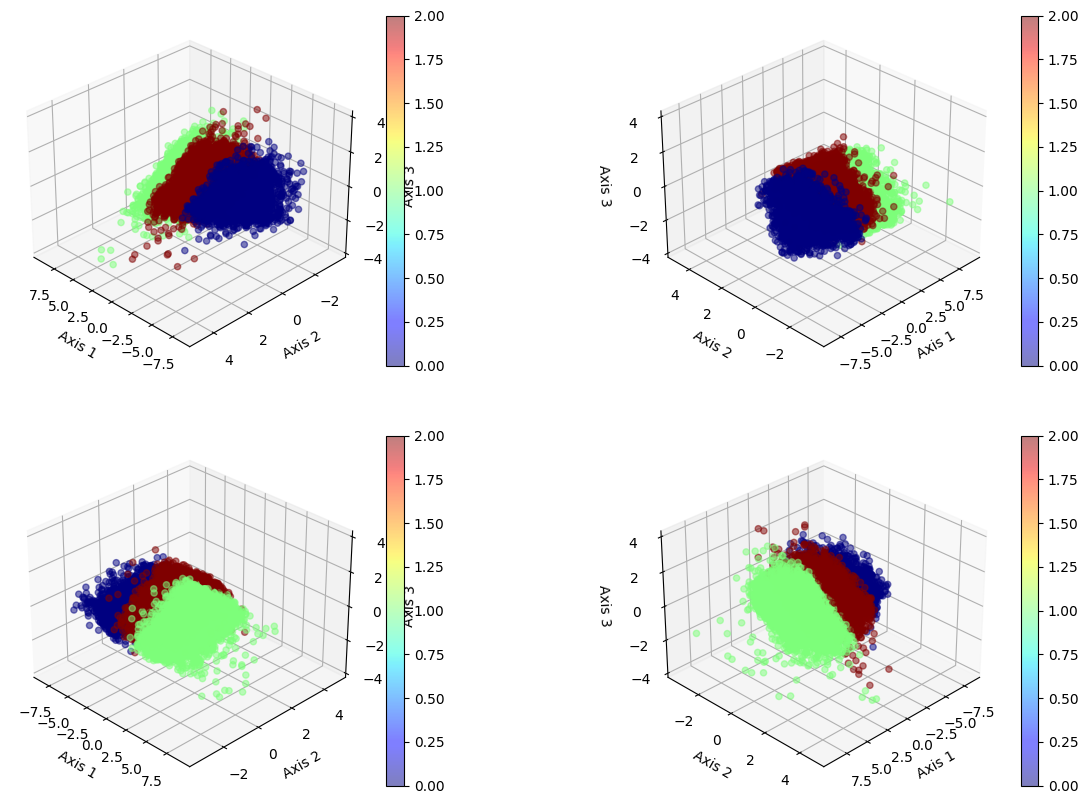

In [27]:
plot_3d(pca_std_3d, data_clus_N, "cluster_label")

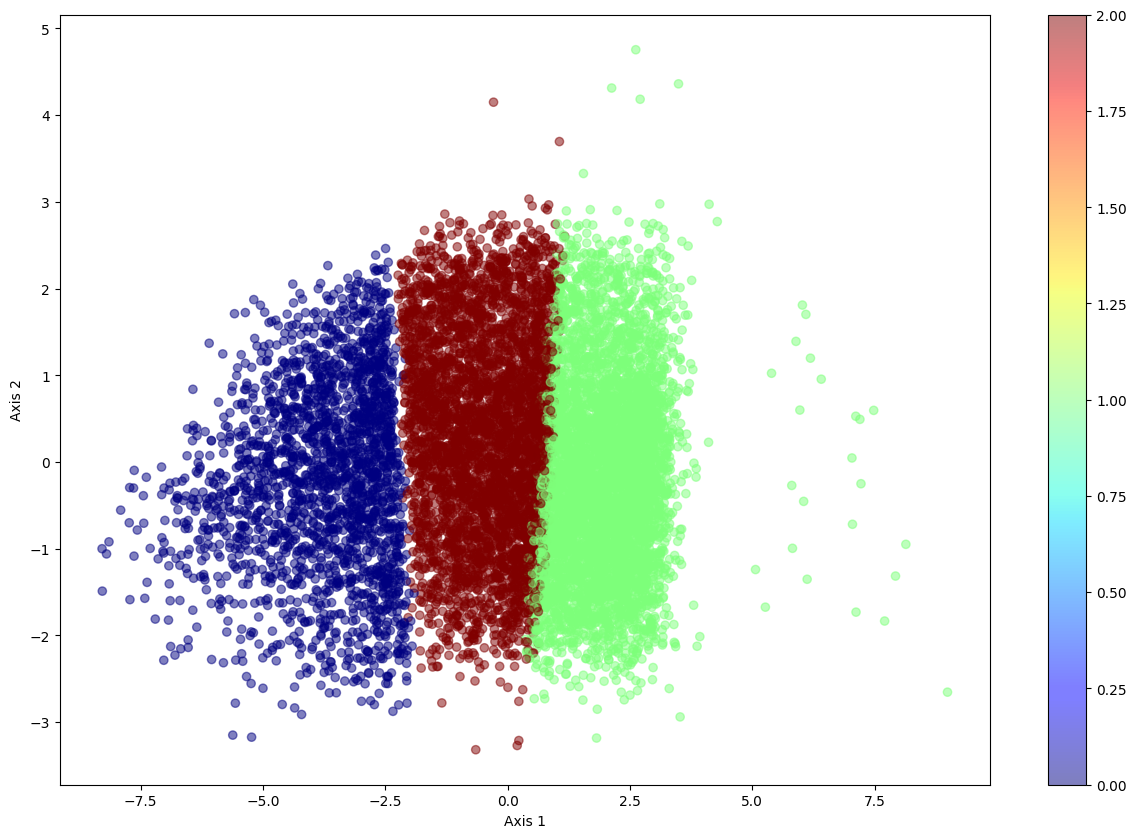

In [28]:
plot_2d(pca_std_2d, data_clus_N, "cluster_label")

## TSNE

In [29]:
tsne_2dim = TSNE(n_components=2, )
tsne_std = tsne_2dim.fit_transform(data_clus_N)

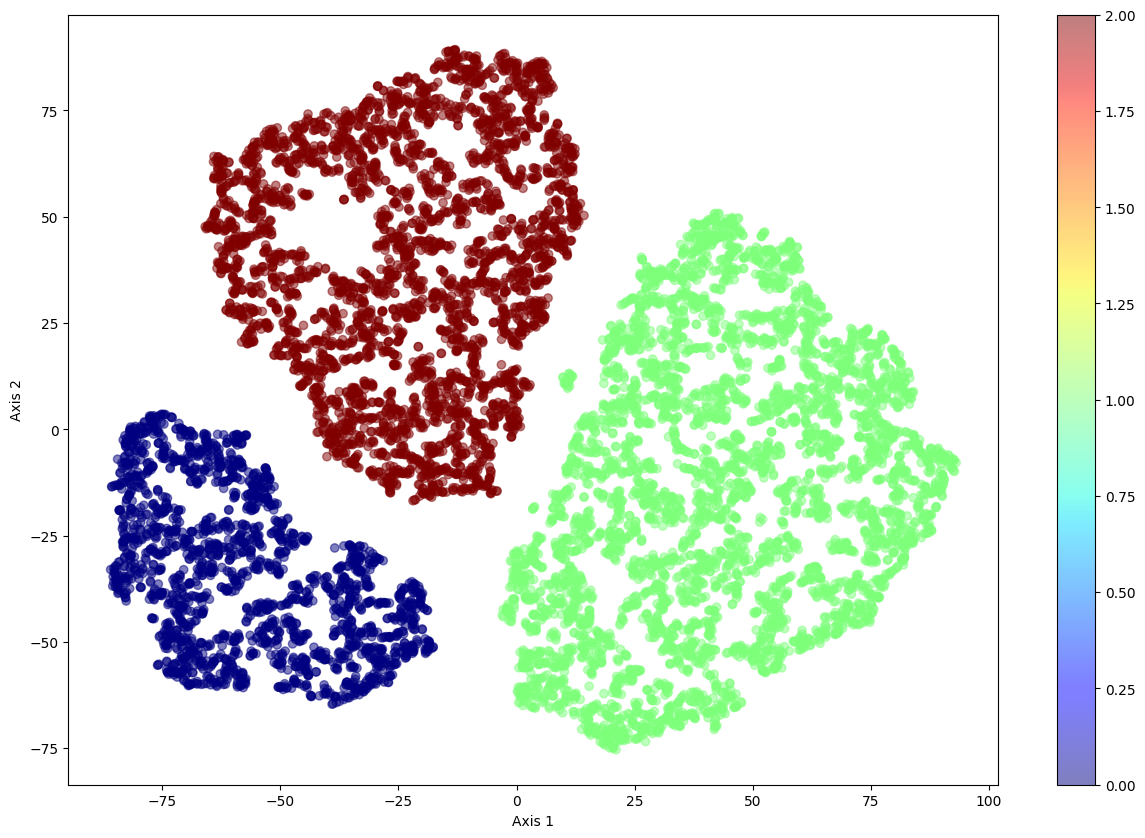

In [30]:
plot_2d(tsne_std, data_clus_N, "cluster_label")

<span style="color:red">**Qué pueden concluir?**</span>  

En Pca se observa la misma tendencia mencionada anteriormente, el cluster 2 parece estar entre medio del cluster 0 y 1.
En cambio en TSNE se observa una clara separacion de clases

KeyError: 'color'

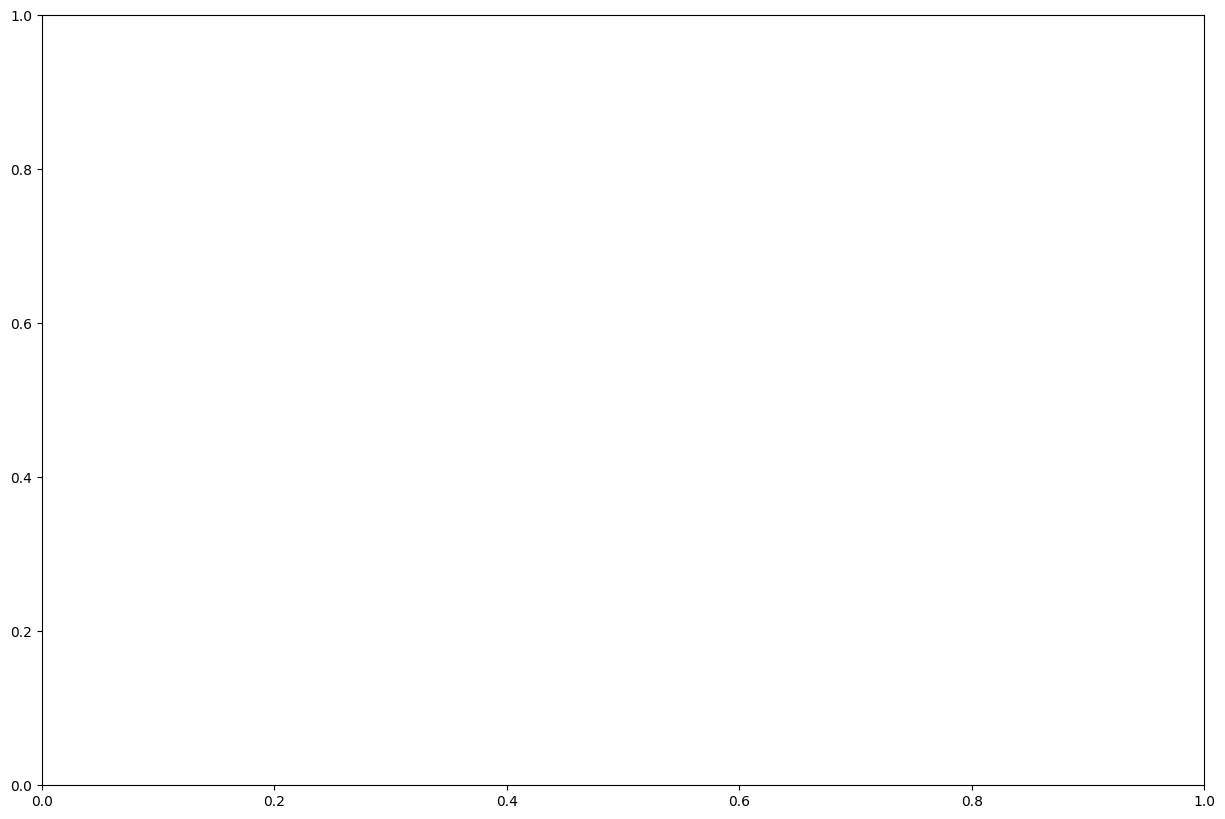

In [32]:
plot_2d(tsne_std, data_clus_N, 'color')